In [9]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity

root = Tk()
root.withdraw()

# 1. read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# 1-1. df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()

# 1-2. mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)


#1-3. data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]
train_data = train_df[feature_vars]
test_data = test_df[feature_vars]

# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


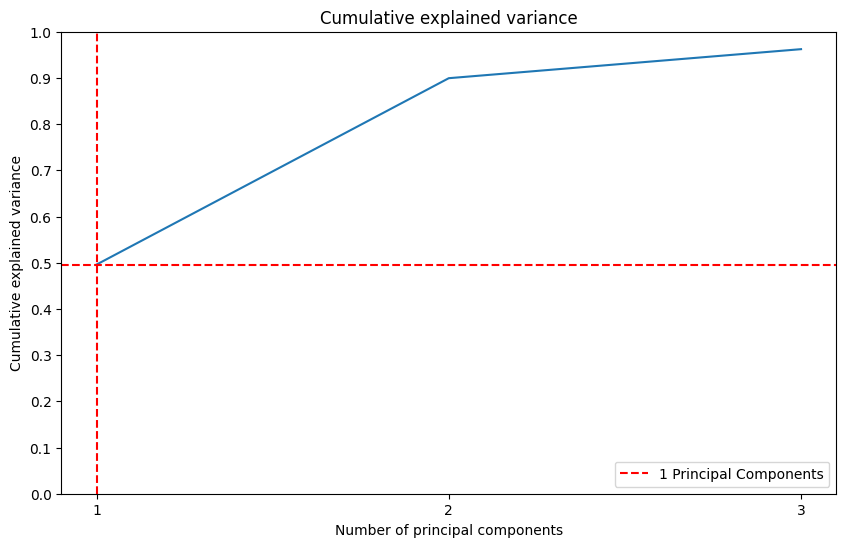

In [10]:
# 2. 次元削減
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)

n_components = min(train_data.shape) - 1
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_scaled)

# 2-1. PCA 可視化：主成分～第n-1成分に対応する累積寄与度 (元のn次元をn-1次元に削減する)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
optimal_components = np.argmax(np.diff(np.cumsum(pca.explained_variance_ratio_), 2))
plt.axvline(x=optimal_components + 1, color='red', linestyle='--', label=f'{optimal_components + 1} Principal Components')
plt.axhline(y=np.cumsum(pca.explained_variance_ratio_)[optimal_components], color='red', linestyle='--')
plt.xticks(ticks=range(1, n_components + 1))  
plt.yticks(ticks=np.arange(0, 1.1, 0.1)) 
plt.legend()
plt.show()

In [11]:
# カテゴリ変数の数値エンコード
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_df['Mode'])
label_names = label_encoder.classes_

# UMAPモデリング (2D)
umap_model_2D = umap.UMAP(n_components=2, random_state=42)
train_umap_2D = umap_model_2D.fit_transform(train_pca)

# UMAPモデリング (3D)
umap_model_3D = umap.UMAP(n_components=3, random_state=42)
train_umap_3D = umap_model_3D.fit_transform(train_pca)


c:\Users\J0114690\AppData\Local\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\J0114690\AppData\Local\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


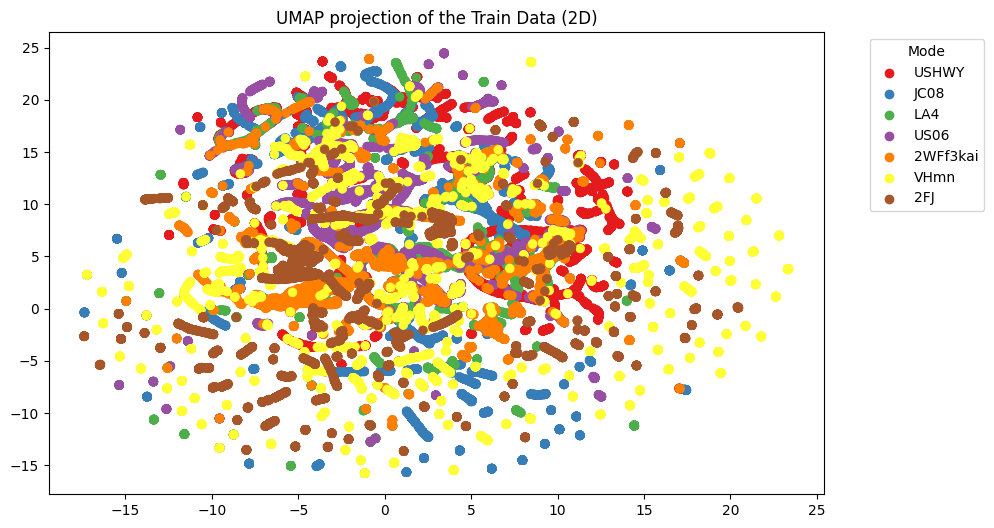

In [12]:
# 2-2. UMAP可視化 (2D)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_umap_2D[:, 0], y=train_umap_2D[:, 1], hue=train_df['Mode'], palette='Set1', s=40, edgecolor=None)
plt.title('UMAP projection of the Train Data (2D)')
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2-2. UMAP可視化 (3D) as HTML
umap_3d_df = pd.DataFrame(train_umap_3D, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_3d_df['Mode'] = train_df['Mode']
fig = px.scatter_3d(umap_3d_df, x='UMAP1', y='UMAP2', z='UMAP3', color='Mode', template='plotly', labels={'color': 'Mode'})
fig.write_html('3D_UMAP.html')


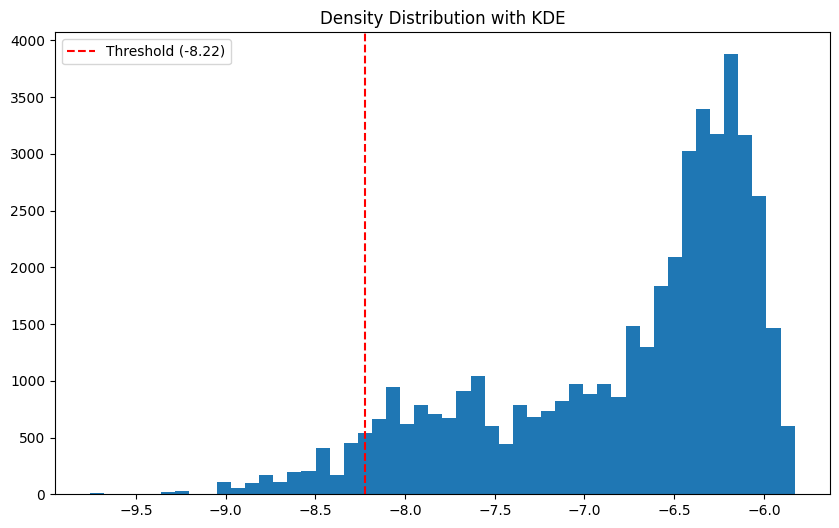

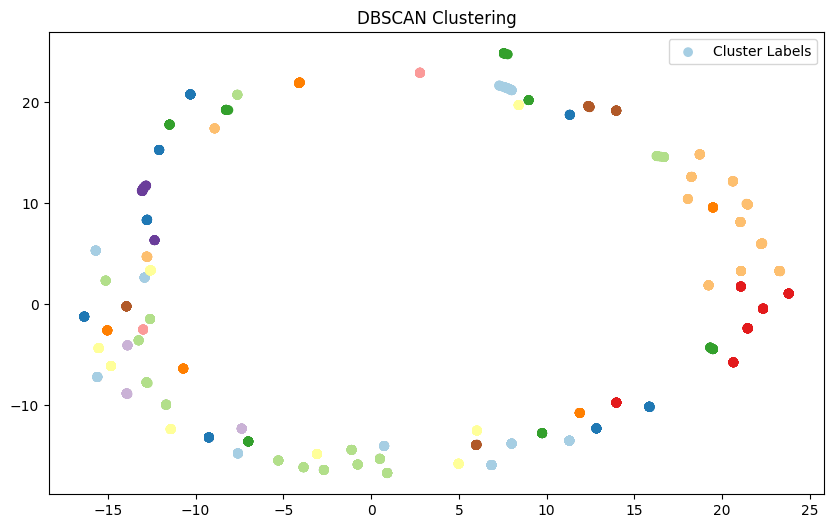

In [9]:
# 3. 密度推定とクラスタリングkde = KernelDensity()
kde.fit(train_umap)

# KDEの密度を計算し、低密度エリアを識別
train_density = kde.score_samples(train_umap)
low_density_threshold = np.percentile(train_density, 5)
is_low_density = train_density < low_density_threshold

# 3-1. KDEの結果をプロット
plt.figure(figsize=(10, 6))
plt.hist(train_density, bins=50)
plt.axvline(x=low_density_threshold, color='red', linestyle='--', label=f'Threshold ({low_density_threshold:.2f})')
plt.title('Density Distribution with KDE')
plt.legend()
plt.show()

# 低密度エリアにDBSCANを適用して外挿エリアを識別
dbscan = DBSCAN()
dbscan_labels_full = dbscan.fit_predict(train_umap) 

# 3-2. DBSCANの結果をプロット
plt.figure(figsize=(10, 6))
plt.scatter(train_umap[is_low_density, 0], train_umap[is_low_density, 1], c=dbscan_labels_full[is_low_density], cmap='Paired', label='Cluster Labels')  # And this line
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

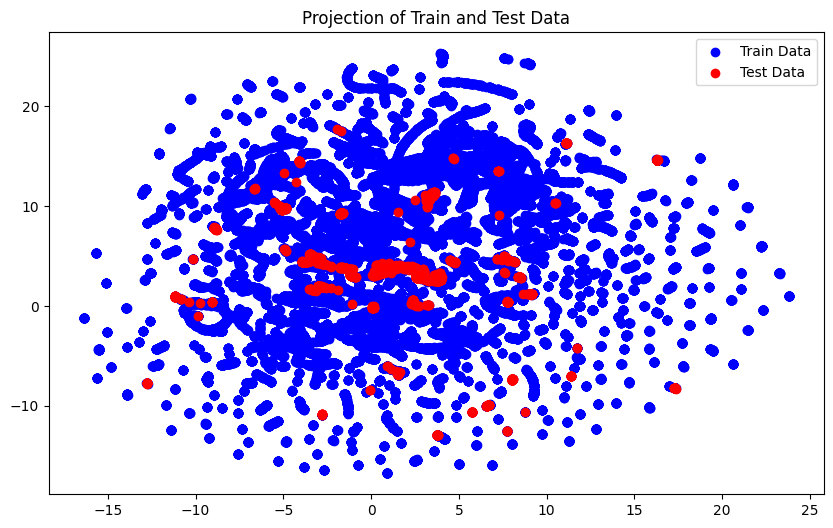

In [10]:
# 4. 検証データのプロット
plt.figure(figsize=(10, 6))
plt.scatter(train_umap[:, 0], train_umap[:, 1], c='blue', label='Train Data')
plt.scatter(test_umap[:, 0], test_umap[:, 1], c='red', label='Test Data')
plt.legend()
plt.title('Projection of Train and Test Data')
plt.show()

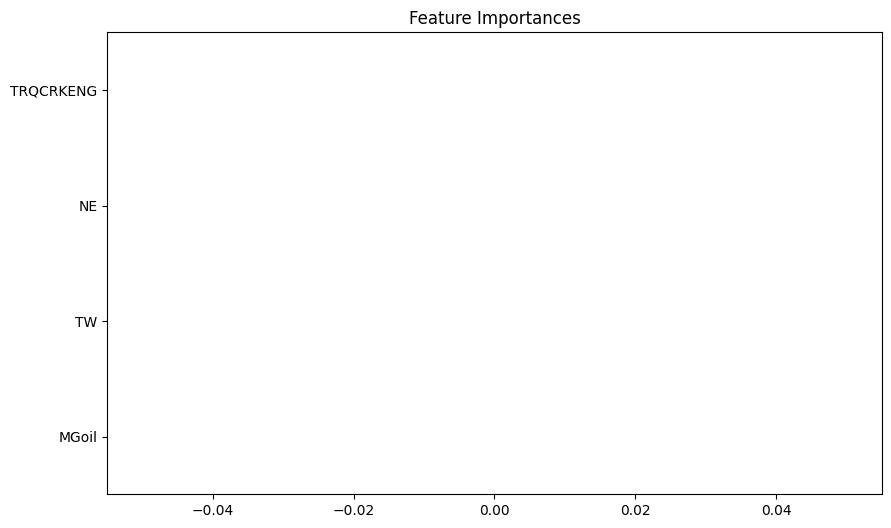

In [11]:
# 5. 高次元空間へのマッピング
# 外挿エリアのインデックスを識別
extrapolation_indices = is_low_density & (dbscan_labels_full == -1)

# 6. 特徴量分析
rf = RandomForestClassifier(random_state=42)
rf.fit(train_data, extrapolation_indices)
feature_importances = rf.feature_importances_

# 6-1. 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=train_data.columns)
plt.title('Feature Importances')
plt.show()
